# Solutions 3 - Examples in Singular Value Decomposition

---

## Assignment 1

All functions from the previous notebook are collected in the file `ModuleB.jl` which contains the module `ModuleB`. 

In [10]:
include("ModuleB.jl")

ModuleB

In [11]:
using ModuleB

## Assignment 2

You can see the availabe images at http://timholy.github.io/TestImages.jl/.

After installing the package with `Pkg.add("TestImages")`, the images are located in the directory `.julia/v0.4/TestImages/images`.

__Hint__: On Windows you may need to edit the file `.julia/v0.4/ImageMagick/dep/deps.jl`,
see bottom of the [issue](https://github.com/JuliaIO/ImageMagick.jl/issues/25).

In [13]:
using TestImages, Images

In [14]:
whos(TestImages)

                    TestImages   4544 bytes  Module
                     testimage      0 bytes  TestImages.#testimage


In [15]:
# whos(Images)

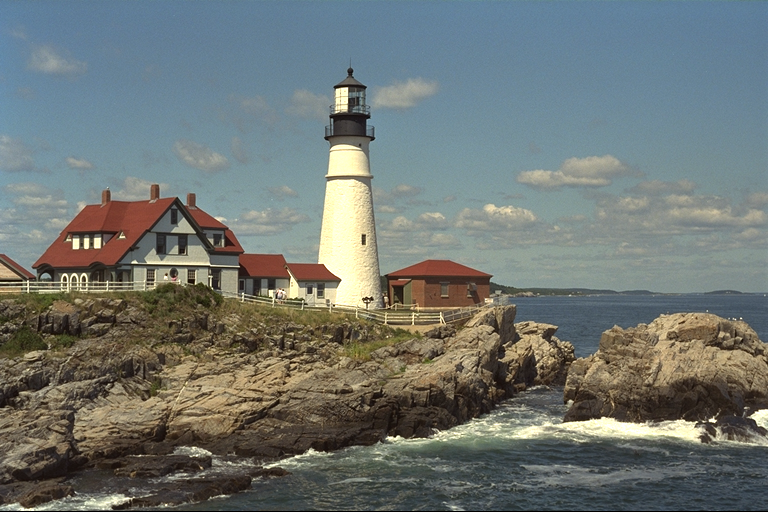

In [17]:
img=testimage("lighthouse")

In [18]:
# Description of the data
show(img)

RGB Images.Image with:
  data: 768×512 Array{ColorTypes.RGB{FixedPointNumbers.UFixed{UInt8,8}},2}
  properties:
    colorspace: sRGB
    spatialorder:  x y

In [19]:
# For example
img[1,1]

In [20]:
show(img[1,1])

RGB{U8}(0.361,0.486,0.6)

In [21]:
# Separate the image into R, G and B components
imgsep=separate(img)
show(imgsep)

RGB Images.Image with:
  data: 512×768×3 Array{FixedPointNumbers.UFixed{UInt8,8},3}
  properties:
    colorspace: RGB
    colordim: 3
    spatialorder:  y x

In [22]:
R=data(imgsep[:,:,1])
G=data(imgsep[:,:,2])
B=data(imgsep[:,:,3])

512×768 Array{FixedPointNumbers.UFixed{UInt8,8},2}:
 UFixed{UInt8,8}(0.6)    UFixed{UInt8,8}(0.588)  …  UFixed{UInt8,8}(0.529)
 UFixed{UInt8,8}(0.6)    UFixed{UInt8,8}(0.608)     UFixed{UInt8,8}(0.58) 
 UFixed{UInt8,8}(0.624)  UFixed{UInt8,8}(0.608)     UFixed{UInt8,8}(0.608)
 UFixed{UInt8,8}(0.62)   UFixed{UInt8,8}(0.624)     UFixed{UInt8,8}(0.588)
 UFixed{UInt8,8}(0.627)  UFixed{UInt8,8}(0.639)     UFixed{UInt8,8}(0.596)
 UFixed{UInt8,8}(0.635)  UFixed{UInt8,8}(0.631)  …  UFixed{UInt8,8}(0.612)
 UFixed{UInt8,8}(0.635)  UFixed{UInt8,8}(0.62)      UFixed{UInt8,8}(0.612)
 UFixed{UInt8,8}(0.635)  UFixed{UInt8,8}(0.62)      UFixed{UInt8,8}(0.616)
 UFixed{UInt8,8}(0.627)  UFixed{UInt8,8}(0.631)     UFixed{UInt8,8}(0.604)
 UFixed{UInt8,8}(0.62)   UFixed{UInt8,8}(0.631)     UFixed{UInt8,8}(0.604)
 UFixed{UInt8,8}(0.643)  UFixed{UInt8,8}(0.631)  …  UFixed{UInt8,8}(0.592)
 UFixed{UInt8,8}(0.659)  UFixed{UInt8,8}(0.624)     UFixed{UInt8,8}(0.608)
 UFixed{UInt8,8}(0.643)  UFixed{UInt8,8}(0.651) 

In [23]:
# Compute the SVD of each component
UR,σR,VR=svd(R)
UG,σG,VG=svd(G)
UB,σB,VB=svd(B);

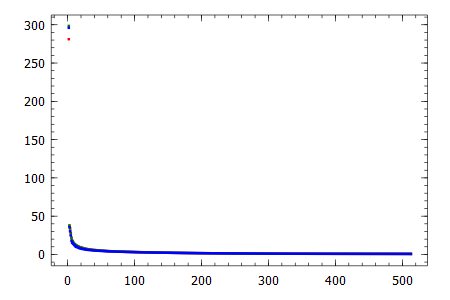

In [25]:
# Plot the singular values
using Winston
x=collect(1:minimum(size(img)))
plot(x,σR,"r.",x,σG,"g.",x,σB,"b.")

In [26]:
# Form compressed matrices for each component
k=50
Rc=UR[:,1:k]*diagm(σR[1:k])*VR[:,1:k]'
Gc=UG[:,1:k]*diagm(σG[1:k])*VG[:,1:k]'
Bc=UB[:,1:k]*diagm(σB[1:k])*VB[:,1:k]'
minimum(Bc),maximum(Bc)

(-0.05907738f0,1.104141f0)

In [27]:
# We need to cut the elements less than 0 and  greater than 1 (this is image!)
Rcc=min(max(Rc,0),1)
Gcc=min(max(Gc,0),1)
Bcc=min(max(Bc,0),1)
minimum(Bcc),maximum(Bcc)

(0.0f0,1.0f0)

In [28]:
# Relative error of approximation
norm(R-Rcc)/norm(R)

0.014841116f0

In [29]:
# Show the compressed image. 
imgcsep=similar(imgsep)
imgcsep[:,:,1]=Rcc
imgcsep[:,:,2]=Gcc
imgcsep[:,:,3]=Bcc
show(imgcsep)

RGB Images.Image with:
  data: 512×768×3 Array{FixedPointNumbers.UFixed{UInt8,8},3}
  properties:
    colorspace: RGB
    colordim: 3
    spatialorder:  y x

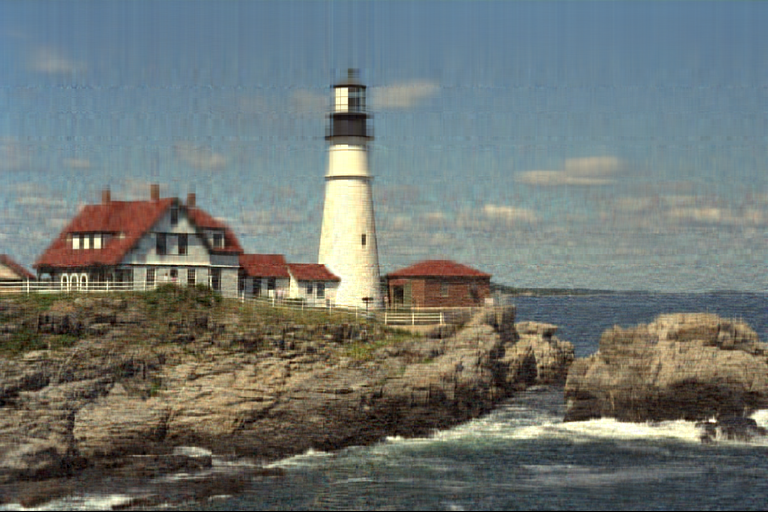

In [30]:
imgcsep

In [31]:
# Now with @manipulate
using Interact

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"",50,50:20:390,"d",true)

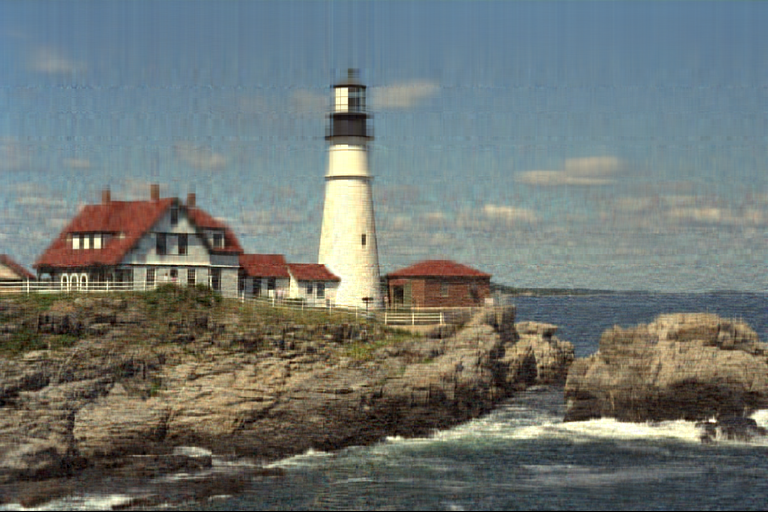

In [32]:
@manipulate for k in slider(50:20:400,value=50)
    Rc=UR[:,1:k]*diagm(σR[1:k])*VR[:,1:k]'
    Gc=UG[:,1:k]*diagm(σG[1:k])*VG[:,1:k]'
    Bc=UB[:,1:k]*diagm(σB[1:k])*VB[:,1:k]'
    Rcc=min(max(Rc,0),1)
    Gcc=min(max(Gc,0),1)
    Bcc=min(max(Bc,0),1)
    imgcsep[:,:,1]=Rcc
    imgcsep[:,:,2]=Gcc
    imgcsep[:,:,3]=Bcc
    imgcsep
end    

## Assignment 3

In [26]:
# Part of the preamble of lapack.jl
const liblapack = Base.liblapack_name
import Base.blasfunc
# import ..LinAlg: BlasFloat, Char, BlasInt, LAPACKException,
    # DimensionMismatch, SingularException, PosDefException, chkstride1, chksquare
import Base.LinAlg.BlasInt
macro assertargsok() #Handle only negative info codes - use only if positive info code 
    # is useful! 
    :(info[1]<0 && throw(ArgumentError("invalid argument #$(-info[1]) to LAPACK call"))) 
end 
macro lapackerror() #Handle all nonzero info codes 
    :(info[1]>0 ? throw(LAPACKException(info[1])) : @assertargsok ) 
end 

In [27]:
for (gesvj, elty) in
    ((:dgesvj_,:Float64),
    (:sgesvj_,:Float32))
    @eval begin
        function gesvj!(A::Array{$elty})
            joba='G'
            jobu='U'
            jobv='V'
            m,n = size(A)
            lda=m
            sva=Array($elty,n)
            mv=1
            V=Array($elty,n,n)
            ldv=n
            lwork=max(6,m+n)
            work = Array($elty, lwork)
            info = Array(BlasInt,1)
            ccall(($(blasfunc(gesvj)), liblapack), Void,
            (Ptr{UInt8}, Ptr{UInt8}, Ptr{UInt8}, 
            Ptr{BlasInt}, Ptr{BlasInt}, Ptr{$elty},
            Ptr{BlasInt}, Ptr{$elty}, Ptr{BlasInt},
            Ptr{$elty}, Ptr{BlasInt}, Ptr{$elty},
            Ptr{BlasInt}, Ptr{BlasInt}),
                &joba, &jobu, &jobv, 
                &m, &n, A, 
                &lda, sva, &mv,
                V, &ldv, work, 
                &lwork, info)
                @lapackerror
            A, sva, V
        end
    end
end

In [28]:
# Small, strongly scaled matrix
m=20
n=15
B=rand(m,n)
D=exp(80*(rand(n)-0.5))
As=B*diagm(D);

In [29]:
U,σ,V=myJacobiR(As)
UL,σL,VL=gesvj!(copy(As))
(sort(σ,rev=true)-σL)./σL

15-element Array{Float64,1}:
  2.86624e-16
  1.37051e-16
  1.67363e-16
  2.96771e-16
 -1.22349e-16
 -1.20475e-16
 -1.86967e-16
  1.11748e-15
  2.90511e-16
 -4.6826e-16 
  0.0        
 -2.27469e-16
 -1.33921e-16
  2.42403e-16
 -1.91758e-16

In [30]:
# Timing for large matrices
n=1000
A=rand(n,n)
@time svd(A);
@time gesvj!(A);

  0.685132 seconds (72.25 k allocations: 56.710 MB, 1.07% gc time)
  9.089616 seconds (10 allocations: 7.653 MB)
